# 1. Introduction
Projek ini dibuat untuk mengembangkan sistem otomatis berbasis deep learning yang dapat mendeteksi dan mengklasifikasikan tingkat keparahan Diabetic Retinopathy pada gambar retina. Input sistem ini berupa gambar retina yang akan diproses menggunakan model deep learning untuk memprediksi apakah gambar tersebut menunjukkan tanda-tanda Diabetic Retinopathy atau tidak. Dengan menggunakan dataset gambar retina yang telah dilabeli, model akan belajar untuk membedakan antara dua kategori: "Diabetic Retinopathy" dan "No Diabetic Retinopathy."

# 2. Import Libraries

In [ ]:
# Downgrade version of TensorFlow and tf-keras

!pip install -q --upgrade "tensorflow<2.16" "tf-keras<2.16"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 r

In [1]:
import tensorflow
tensorflow.__version__

'2.15.1'

In [2]:
# cek bahwa gpu telah terpasang di google colab
!nvidia-smi

Sun Jun  1 18:52:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   49C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Menginstal library kaggle untuk mengakses dataset langsung dari Kaggle
!pip install -q kaggle

# Mengimpor berbagai library yang diperlukan
import os  # Digunakan untuk berinteraksi dengan sistem file (akses file/folder)
import glob  # Digunakan untuk mencari file dengan pola tertentu
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import shutil  # Digunakan untuk operasi file tingkat tinggi (menyalin/memindahkan file)
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import untuk preprocessing gambar
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mengimpor komponen untuk membangun model deep learning
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, GlobalAveragePooling2D, concatenate

# Mengimpor model pra-latih Xception yang bisa digunakan untuk fine-tuning
from tensorflow.keras.applications import Xception

# Mengimpor metrik untuk mengevaluasi model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Mengimpor library untuk mengatur peringatan
import warnings
warnings.filterwarnings('ignore')

# 3. Data Loading

In [4]:
# Buat folder .kaggle jika belum ada
os.makedirs("/root/.kaggle", exist_ok=True)

# Pindahkan file ke folder tersebut
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Atur permission agar file bisa digunakan
os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
# download sumber dataset dari kaggle
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy
License(s): MIT
  0% 0.00/30.1M [00:00<?, ?B/s]
100% 30.1M/30.1M [00:00<00:00, 1.21GB/s]


In [6]:
# Ekstrak dataset lalu disimpan didalam folder images
!unzip -q '/content/diagnosis-of-diabetic-retinopathy.zip' -d images

replace images/Diagnosis of Diabetic Retinopathy/test/DR/00cb6555d108_png.rf.29cca170969c6e9918ef9b9209abef8e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
# Menampilkan daftar file yang ada di folder 'images'
os.listdir('/content/images')

['retino', 'Diagnosis of Diabetic Retinopathy']

In [8]:
# Membuat 'main_path' yang berisi direktori 'image'
main_path = '/content/images/Diagnosis of Diabetic Retinopathy'

## Menampilkan informasi dataset

In [9]:
# Membuat direktori dari masing-masing folder train, test dan validasi
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
val_dir = os.path.join(main_path, 'valid')

In [10]:
# Menampilkan jumlah data pada data train untuk kategori 'DR' (Diabetic Retinopathy) dan 'No_DR' (Non-Diabetic Retinopathy)
print('train set: \n' + '='*50)
num_dr= len(os.listdir(os.path.join(train_dir, 'DR')))
num_no_dr= len(os.listdir(os.path.join(train_dir, 'No_DR')))
print(f'jumlah DR= {num_dr}')
print(f'jumlah No_DR= {num_no_dr}')

train set: 
jumlah DR= 1050
jumlah No_DR= 1026


Terlihat dari informasi di atas bahwa train set memiliki 2 folder yaitu folder DR yang memiliki jumlah file 1050 dan folder No_DR memiliki jumlah file sebanyak 1026

In [11]:
# Menampilkan jumlah data pada data test untuk kategori 'DR' (Diabetic Retinopathy) dan 'No_DR' (Non-Diabetic Retinopathy)
print('test set: \n' + '='*50)
num_dr= len(os.listdir(os.path.join(test_dir, 'DR')))
num_no_dr= len(os.listdir(os.path.join(test_dir, 'No_DR')))
print(f'jumlah DR= {num_dr}')
print(f'jumlah No_DR= {num_no_dr}')

test set: 
jumlah DR= 113
jumlah No_DR= 118


Terlihat dari informasi di atas bahwa test set memiliki 2 folder yaitu folder DR yang memiliki file sebanyak 113 dan folder No_DR sebanyak 118 file

In [12]:
# Menampilkan jumlah data pada data val untuk kategori 'DR' (Diabetic Retinopathy) dan 'No_DR' (Non-Diabetic Retinopathy)
print('val set: \n' + '='*50)
num_dr= len(os.listdir(os.path.join(val_dir, 'DR')))
num_no_dr= len(os.listdir(os.path.join(val_dir, 'No_DR')))
print(f'jumlah DR= {num_dr}')
print(f'jumlah No_DR= {num_no_dr}')

val set: 
jumlah DR= 245
jumlah No_DR= 286


Terlihat dari informasi di atas bahwa val set memiliki 2 folder yaitu folder DR yang memiliki file sebanyak 245 dan folder No_DR sebanyak 286 file

In [13]:
# Mengumpulkan nama file gambar untuk setiap kategori (DR dan No_DR) dari train, test, dan validasi menggunakan glob
train_dr = glob.glob(train_dir+"/DR/*.jpg")
train_no_dr = glob.glob(train_dir+"/No_DR/*.jpg")

test_dr = glob.glob(test_dir+"/DR/*.jpg")
test_no_dr = glob.glob(test_dir+"/No_DR/*.jpg")

val_dr = glob.glob(val_dir+"/DR/*.jpg")
val_no_dr = glob.glob(val_dir+"/No_DR/*.jpg")

Selanjutnya saya akan membuat dataframe agar data gambar tersusun rapi ke dalam tabel dan kemudian akan mempermudah untuk melakukan uji data

In [14]:
# Membuat dataframe dari daftar gambar
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_dr + train_no_dr)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_dr + test_no_dr)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

val_df = create_dataframe(val_dr + val_no_dr)
val_df = val_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [15]:
# Menampilkan data train
print(train_df.shape)
train_df.head()

(2076, 2)


,images,label
0,/content/images/Diagnosis of Diabetic Retinopa...,DR
1,/content/images/Diagnosis of Diabetic Retinopa...,DR
2,/content/images/Diagnosis of Diabetic Retinopa...,DR
3,/content/images/Diagnosis of Diabetic Retinopa...,No_DR
4,/content/images/Diagnosis of Diabetic Retinopa...,No_DR


In [16]:
# Menampilkan data test
print(test_df.shape)
test_df.head()

(231, 2)


,images,label
0,/content/images/Diagnosis of Diabetic Retinopa...,DR
1,/content/images/Diagnosis of Diabetic Retinopa...,No_DR
2,/content/images/Diagnosis of Diabetic Retinopa...,No_DR
3,/content/images/Diagnosis of Diabetic Retinopa...,No_DR
4,/content/images/Diagnosis of Diabetic Retinopa...,No_DR


In [17]:
# Menampilkan data val
print(val_df.shape)
val_df.head()

(531, 2)


,images,label
0,/content/images/Diagnosis of Diabetic Retinopa...,DR
1,/content/images/Diagnosis of Diabetic Retinopa...,No_DR
2,/content/images/Diagnosis of Diabetic Retinopa...,No_DR
3,/content/images/Diagnosis of Diabetic Retinopa...,No_DR
4,/content/images/Diagnosis of Diabetic Retinopa...,No_DR


# 4. Exploratory Data Analysis (EDA)

## 4.1 Menampilkan perbandingan ukuran gambar (tinggi dan lebar) antara label pada train_df dan val_df, sehingga memberi informasi tentang variasi ukuran gambar dalam dataset.

In [18]:
def visualize_image_size_distribution(dataframe, split_name='Dataset'):
    import cv2
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    df = dataframe.copy()
    heights = []
    widths = []

    for img_path in df['images']:
        img = cv2.imread(img_path)
        if img is not None:
            height, width = img.shape[:2]
            heights.append(height)
            widths.append(width)
        else:
            print(f"Warning: Gambar gagal dibaca: {img_path}")
            heights.append(None)
            widths.append(None)

    df['height'] = heights
    df['width'] = widths

    # Hapus entri yang gagal dibaca
    df = df.dropna(subset=['height', 'width'])

    size_data = df.groupby('label')[['height', 'width']].mean().reset_index()

    fig, ax = plt.subplots(figsize=(8, 5))
    size_data_melted = size_data.melt(id_vars="label", value_vars=["height", "width"],
                                      var_name="Dimension", value_name="Size")

    sns.barplot(x="label", y="Size", hue="Dimension", data=size_data_melted, ax=ax, palette='viridis')

    ax.set_title(f'{split_name} Image Size Distribution', size=14)
    ax.set_xlabel('Label', size=14)
    ax.set_ylabel('Average Size (px)', size=14)
    plt.tight_layout()
    plt.show()

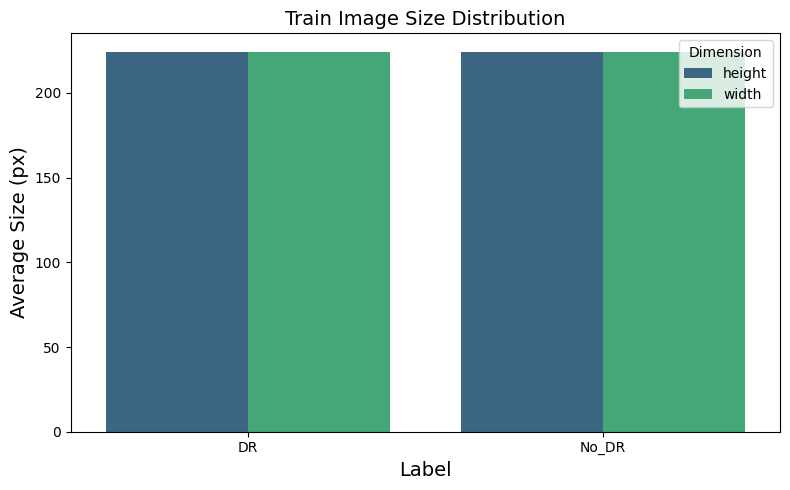

In [19]:
# menampilkan visualisasi pada train_df
visualize_image_size_distribution(train_df, 'Train')

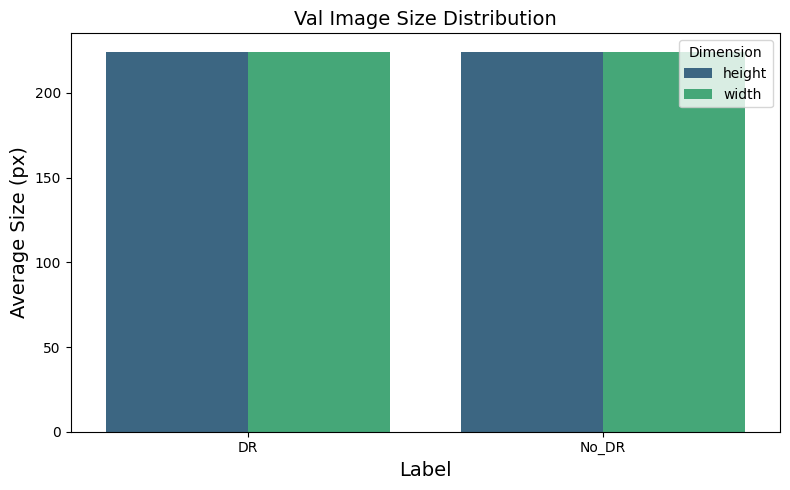

In [20]:
# menampilkan visualisasi pada val_df
visualize_image_size_distribution(val_df, 'Val')

Berdasarkan visualisasi distribusi ukuran gambar pada data train dan val, terlihat bahwa rata-rata tinggi dan lebar gambar untuk masing-masing label, yaitu Diabetic Retinopathy (DR) dan No Diabetic Retinopathy (No_DR) memiliki nilai yang hampir sama. Hal ini menunjukkan bahwa dimensi gambar relatif konsisten di seluruh kelas, sehingga proses preprocessing seperti resizing dapat dilakukan secara seragam tanpa menimbulkan distorsi yang berbeda antar label.

## 4.2 Menampilkan distribusi warna (RGB) rata-rata per label pada data train dan val

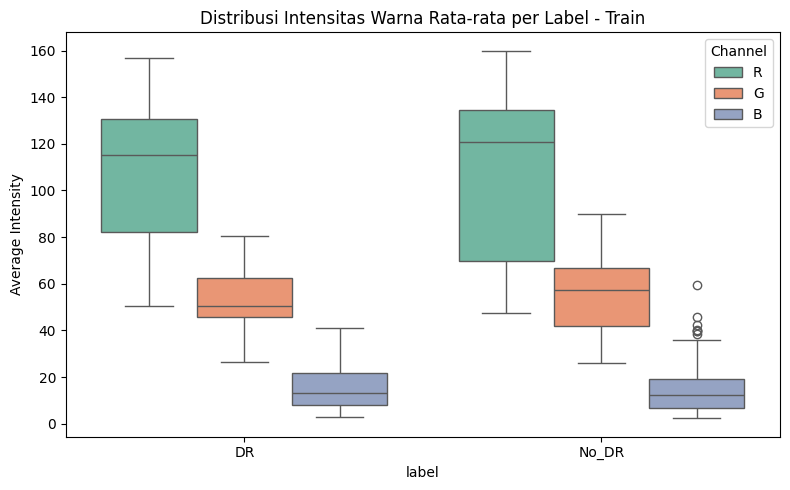

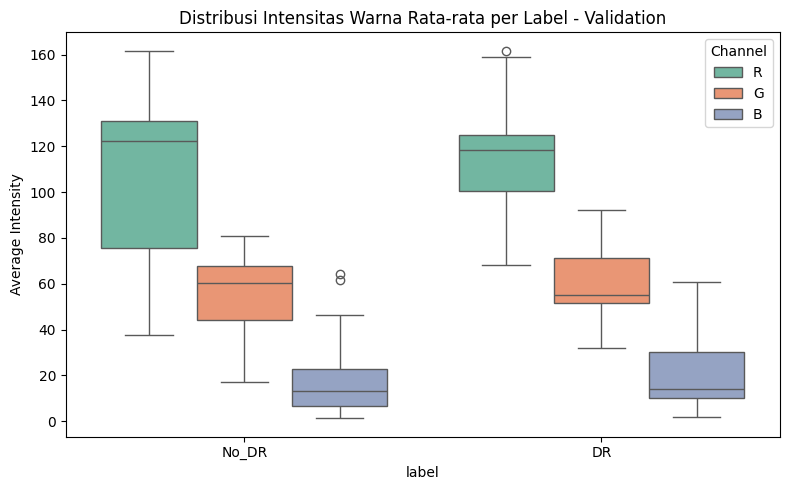

In [21]:
def compute_avg_rgb(df, sample_size=100):
    # Ambil sampel agar proses lebih ringan
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=1)
    rgb_data = {'label': [], 'R': [], 'G': [], 'B': []}

    for path, label in zip(df_sample['images'], df_sample['label']):
        img = cv2.imread(path)
        if img is not None:
            # Konversi BGR ke RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            avg_color = img.mean(axis=(0, 1))  # Rata-rata tiap channel
            rgb_data['label'].append(label)
            rgb_data['R'].append(avg_color[0])
            rgb_data['G'].append(avg_color[1])
            rgb_data['B'].append(avg_color[2])

    return pd.DataFrame(rgb_data)

# Hitung rata-rata RGB untuk masing-masing label di train dan val
train_rgb_df = compute_avg_rgb(train_df)
val_rgb_df = compute_avg_rgb(val_df)

# Visualisasi distribusi warna rata-rata
def plot_avg_rgb(data, title):
    melted = data.melt(id_vars='label', value_vars=['R', 'G', 'B'], var_name='Channel', value_name='Average Intensity')
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='label', y='Average Intensity', hue='Channel', data=melted, palette='Set2')
    plt.title(f'Distribusi Intensitas Warna Rata-rata per Label - {title}')
    plt.tight_layout()
    plt.show()

plot_avg_rgb(train_rgb_df, "Train")
plot_avg_rgb(val_rgb_df, "Validation")

Berdasarkan visualisasi distribusi intensitas warna rata-rata per channel (R, G, B), terlihat bahwa gambar dari kedua label yaitu DR maupun No_DR cenderung memiliki intensitas warna merah (R) yang lebih tinggi dibandingkan channel hijau (G) dan biru (B). channel biru menunjukkan intensitas yang paling rendah dan variasi yang sempit di kedua label. Meskipun terdapat sedikit perbedaan dalam sebaran intensitas warna antar label, pola distribusi warna secara umum relatif konsisten antara data pelatihan dan validasi. Hal ini menunjukkan bahwa karakteristik warna dasar gambar serupa pada kedua label dan antar subset data, sehingga tidak terjadi ketimpangan signifikan dari sisi representasi warna

## 4.3 Menampilkan visualisasi distribusi jumlah gambar per label pada data train dan val

In [22]:
def plot_label_counts(df, dataset_name):
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x='label', palette='Set1')

    # Tambahkan anotasi jumlah pada tiap bar
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}',
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

    # Judul dan label sumbu
    ax.set_title(f'Distribusi Label pada {dataset_name}', fontsize=14)
    ax.set_xlabel('Label', fontsize=12)
    ax.set_ylabel('Jumlah Gambar', fontsize=12)

    plt.tight_layout()
    plt.show()

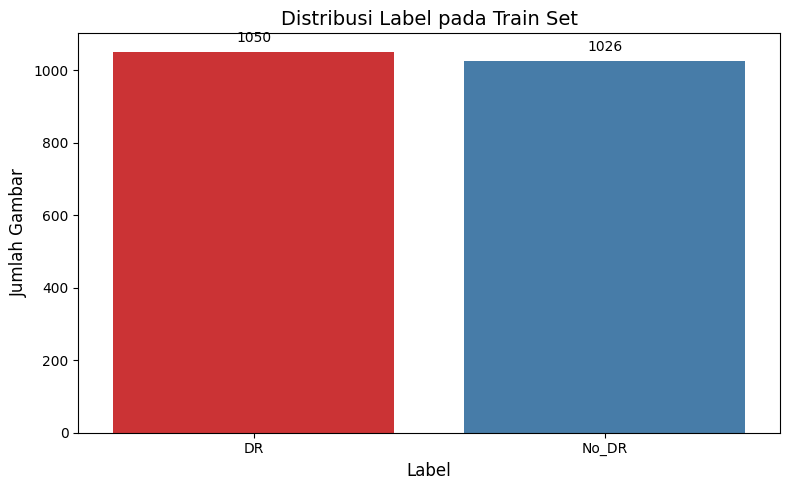

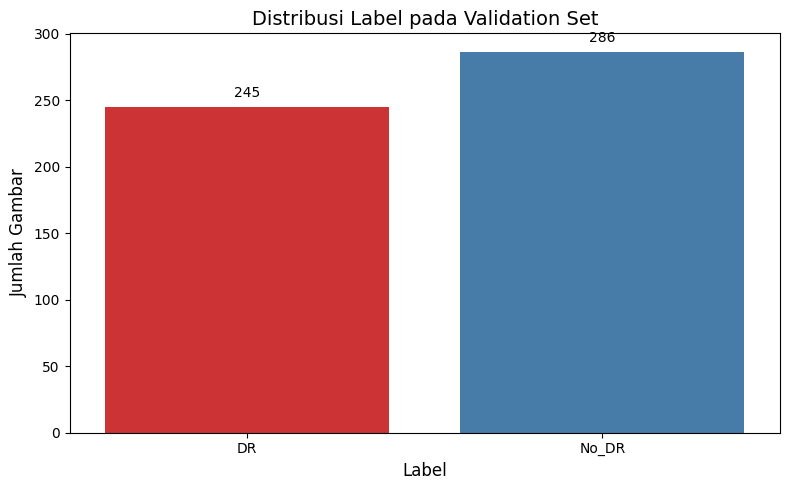

In [23]:
plot_label_counts(train_df, 'Train Set')
plot_label_counts(val_df, 'Validation Set')

Terlihat pada gambar di atas bahwa jumlah gambar untuk masing-masing kelas — Diabetic Retinopathy (DR) dan No Diabetic Retinopathy (No_DR) relatif seimbang. Pada train set terdapat 1.050 gambar untuk label DR dan 1.026 gambar untuk label No_DR. Sedangkan pada validation set terdapat 245 gambar DR dan 286 gambar No_DR.

## 4.4 Menampilkan visualisasi untuk mengetahui ciri bentuk seperti kontur atau struktur pada citra retina

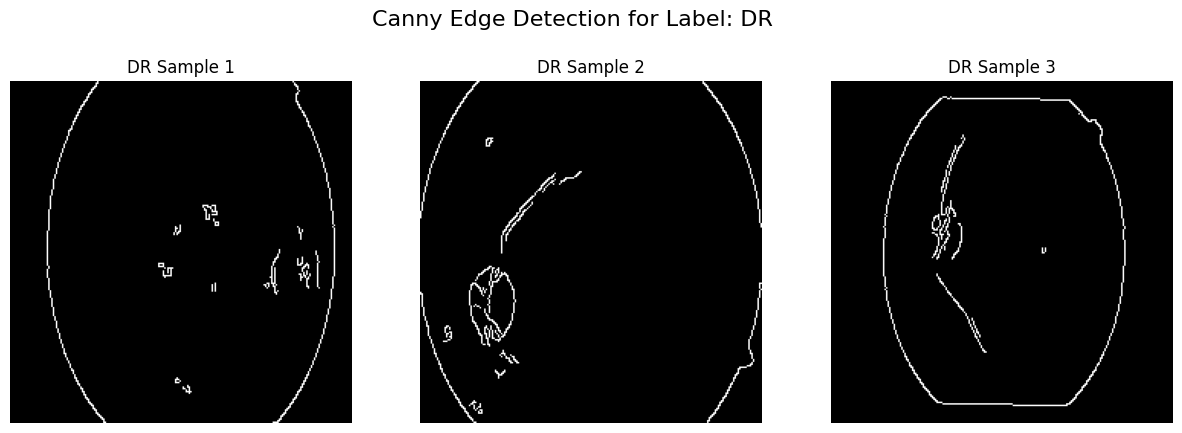

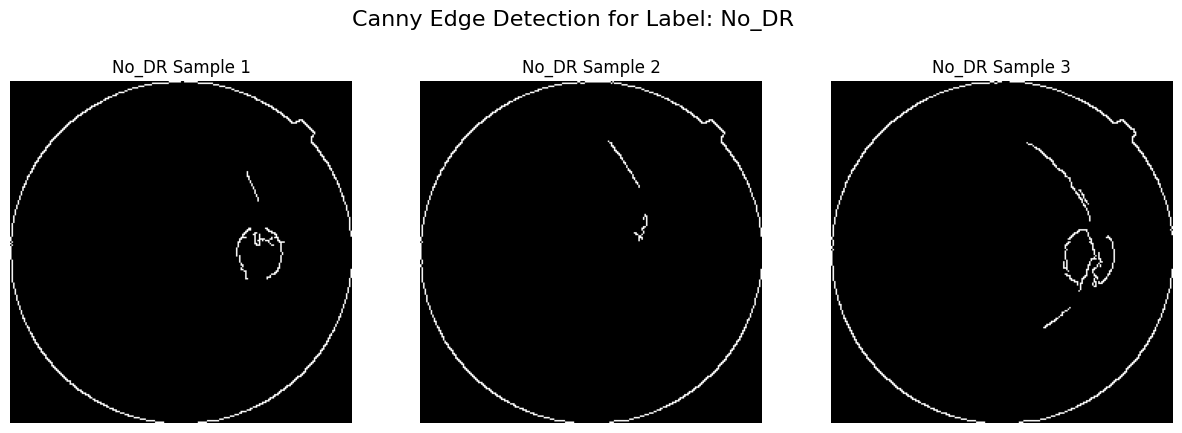

In [24]:
def show_sample_edges(df, label, num_samples=3):
    sample_paths = df[df['label'] == label]['images'].sample(n=min(num_samples, len(df)), random_state=8).values

    plt.figure(figsize=(15, 5))
    for i, path in enumerate(sample_paths):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(img, 100, 200)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(edges, cmap='gray')
        plt.title(f'{label} Sample {i+1}')
        plt.axis('off')
    plt.suptitle(f'Canny Edge Detection for Label: {label}', fontsize=16)
    plt.show()

# Tampilkan contoh bentuk/struktur pada label DR dan No_DR
show_sample_edges(train_df, 'DR')
show_sample_edges(train_df, 'No_DR')


Berdasarkan gambar di atas, terlihat bahwa gambar dengan label Diabetic Retinopathy (DR) cenderung memiliki lebih banyak pola tepi yang kompleks, terutama di area sekitar pusat retina. Terdapat juga bercak atau bintik-bintik. Ini mencerminkan adanya lesi, pembuluh darah abnormal, atau mikroaneurisma yang merupakan ciri khas dari DR. Sebaliknya, gambar dengan label No_DR umumnya menunjukkan pola tepi yang lebih sederhana dan lebih sedikit, menandakan struktur retina yang lebih normal tanpa indikasi penyakit.

## 4.5 Menampilkan visualisasi gambar retina untuk setiap label (DR dan No_DR)

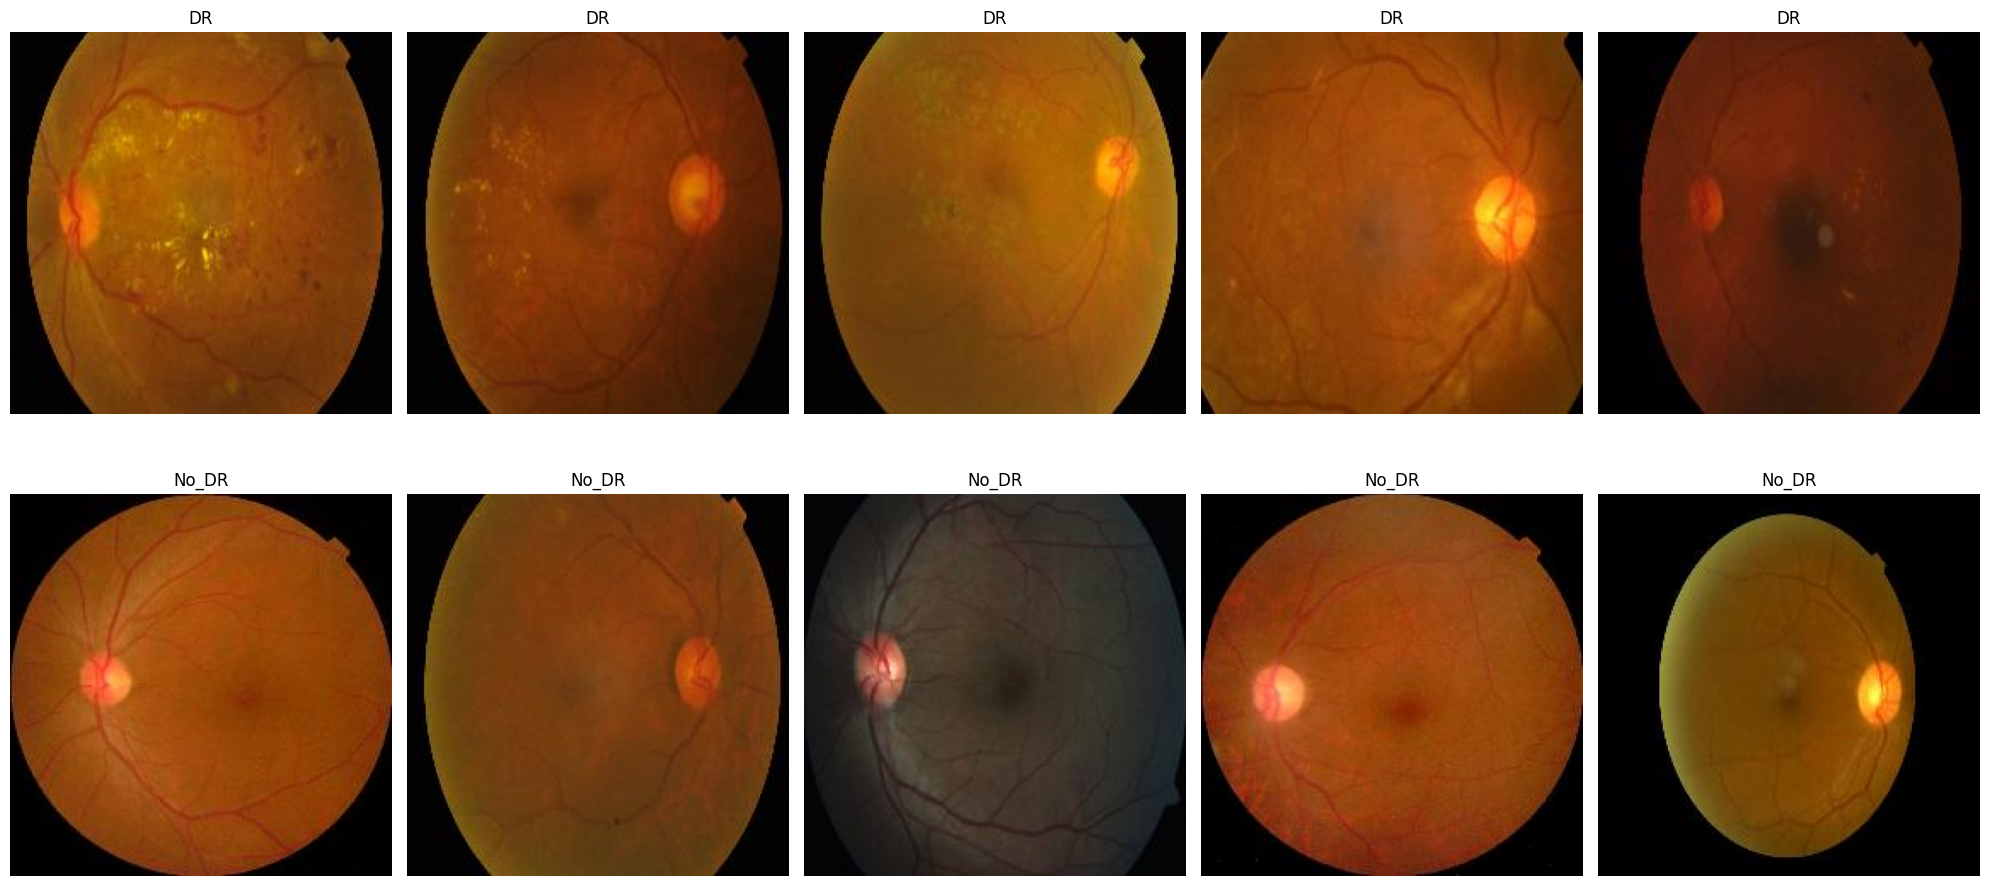

In [25]:
# Mengambil 5 sampel gambar dari masing-masing kelas
dr_examples = train_df[train_df['label'] == 'DR']['images'].head(5).tolist()
no_dr_examples = train_df[train_df['label'] == 'No_DR']['images'].head(5).tolist()

# Fungsi untuk menampilkan kumpulan gambar
def display_sample_images(image_paths):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()

    for idx, path in enumerate(image_paths):
        image = cv2.imread(path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image_rgb)
        axes[idx].set_title(path.split('/')[-2])
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan sampel gambar dari kedua label
display_sample_images(dr_examples + no_dr_examples)


Terlihat perbedaan pada gambar di atas dimana gambar dengan label DR, terlihat adanya bercak putih atau kuning, perdarahan kecil, serta pola pembuluh darah yang lebih kompleks dan tidak teratur yang mengindikasikan ciri khas dari retinopati diabetik. Sementara itu, gambar dengan label No_DR menunjukkan struktur retina yang lebih bersih dan seragam tanpa adanya kelainan mencolok.

# 5. Feature Engineering
## Augmentasi Data

Pada tahap ini, dilakukan augmentasi data dengan menambah variasi citra pelatihan tanpa menambah data baru secara manual. Tujuannya adalah agar model dapat mengenali pola penting meskipun gambar mengalami perubahan posisi, pencahayaan, atau ukuran, sehingga model menjadi lebih robust dan tidak overfitting.

In [26]:
# pengaturan dasar untuk augmentasi gambar
img_height= 220
img_width= 220
augmentation_seed = 1
batch_limit = 64

Berdasarkan informasi di atas, pengaturan ukuran gambar, batch, dan seed ditentukan sebelum proses augmentasi untuk memastikan seluruh gambar diresize secara seragam dan augmentasi berjalan konsisten. Ini penting agar model belajar dari variasi gambar yang realistis tanpa mengubah struktur anatomi retina secara ekstrem.

In [27]:
# Generator gambar dengan augmentasi untuk proses training
augment_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator validasi tanpa augmentasi, hanya normalisasi
augment_val = ImageDataGenerator(rescale=1./255)

# Generator untuk data pengujian, hanya scaling pixel
augment_test = ImageDataGenerator(rescale=1./255)

Berdasarkan informasi di atas, saya  melakukan augmentasi pada data training agar model lebih robust, serta melakukan normalisasi pada data validasi dan pengujian untuk memastikan evaluasi yang konsisten.

In [28]:
# Membuat dataset dari dataframe untuk pelatihan, validasi, dan pengujian

train_flow = augment_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),  # Menyamakan ukuran semua gambar
    class_mode='binary',
    batch_size=batch_limit,
    shuffle=True,
    seed=augmentation_seed
)

val_flow = augment_val.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=batch_limit,
    shuffle=False,
    seed=augmentation_seed
)

test_flow = augment_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=batch_limit,
    shuffle=False,
    seed=augmentation_seed
)

Found 2076 validated image filenames belonging to 2 classes.
Found 531 validated image filenames belonging to 2 classes.
Found 231 validated image filenames belonging to 2 classes.


Selanjutnya, saya akan mengubah tipe data pada label DR dan No_DR dari bentuk string menjadi format numerik biner, di mana DR dikonversi menjadi 0 dan No_DR menjadi 1, agar dapat digunakan dalam pemodelan klasifikasi.

In [29]:
# mengubah tipe label menjadi numerik
train_flow.class_indices

{'DR': 0, 'No_DR': 1}

# 6. ANN Training (Sequential API)

## 6.1 Model Definition

In [30]:
# Clear session

import tensorflow as tf
tf.keras.backend.clear_session()
np.random.seed(augmentation_seed)
tf.random.set_seed(augmentation_seed)

In [31]:
# Menentukan ukuran input untuk citra (tinggi, lebar, dan jumlah channel warna)
input_shape = [img_height, img_width, 3]

# Membuat arsitektur model menggunakan pendekatan Sequential
cnn_model = Sequential()

# Blok pertama: Conv + MaxPooling
cnn_model.add(Conv2D(32, kernel_size=3, kernel_initializer=tf.keras.initializers.HeNormal(augmentation_seed),
                     activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

# Blok kedua: Conv (dengan padding) + MaxPooling
cnn_model.add(Conv2D(32, kernel_size=3, kernel_initializer=tf.keras.initializers.HeNormal(augmentation_seed),
                     activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

# Blok ketiga: Conv + MaxPooling
cnn_model.add(Conv2D(64, kernel_size=3, kernel_initializer=tf.keras.initializers.HeNormal(augmentation_seed),
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten dan Dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))


Pemilihan ReLU sebagai fungsi aktivasi digunakan karena efisien dan mampu menghindari vanishing gradient, sedangkan sigmoid dipilih pada output layer karena model melakukan klasifikasi biner. HeNormal initializer digunakan karena cocok dengan ReLU dan membantu mempercepat konvergensi. Sementara itu, MaxPooling berfungsi untuk mengurangi dimensi fitur dan kompleksitas model, sehingga meningkatkan efisiensi dan mencegah overfitting.

In [32]:
# mengecek summary informasi model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

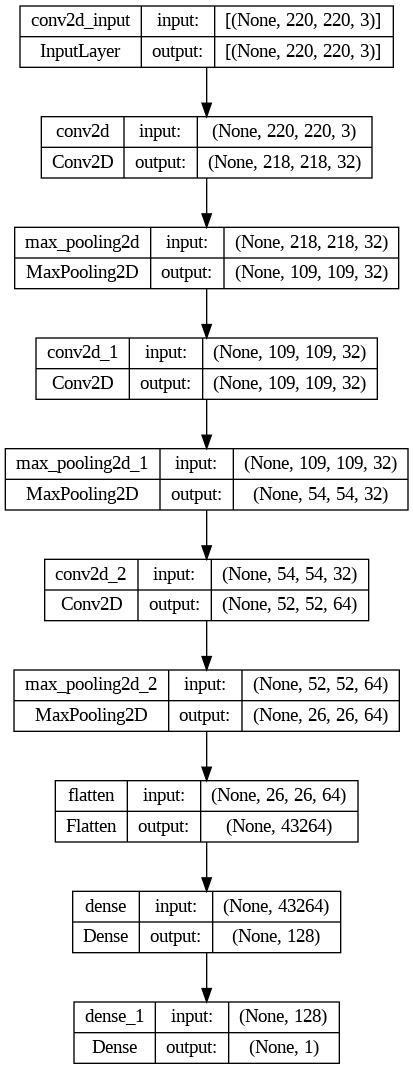

In [33]:
# membuat arsitektur model sequential
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

Berdasarkan hasil arsitektur di atas, terdapat informasi sebagai berikut:
- Input Layer: menerima gambar berukuran 220x220 piksel dengan 3 channel warna (RGB).

- Conv2D + MaxPooling 1:

  Layer konvolusi pertama menggunakan 32 filter dengan kernel 3x3. Padding default (valid) menyebabkan sedikit pengurangan dimensi.

  Diikuti oleh max pooling 2x2 untuk mereduksi dimensi spasial menjadi setengah.

- Conv2D + MaxPooling 2:

  Layer konvolusi kedua juga menggunakan 32 filter dengan padding 'same', sehingga ukuran tidak berubah.

  Max pooling kembali dilakukan untuk mereduksi dimensi spasial.

- Conv2D + MaxPooling 3:

  Layer konvolusi ketiga memiliki 64 filter dengan padding default. Ukuran output menyusut lebih jauh.

  Max pooling terakhir mengurangi dimensi menjadi (26, 26, 64).

- Flatten:

  Mengubah output 3D dari konvolusi menjadi vektor 1D berukuran 43.264 yang dapat diteruskan ke Dense layer.

- Dense Layer:

  Layer fully connected pertama memiliki 128 neuron dengan aktivasi ReLU.

  Layer output memiliki 1 neuron dengan aktivasi sigmoid, yang menghasilkan probabilitas antara 0–1 untuk klasifikasi biner.

## 6.2 Model Training

In [34]:
# Menyiapkan callback untuk proses training model
seq_callback = [
    EarlyStopping(monitor='val_loss', patience=3),  # Menghentikan training jika tidak ada peningkatan pada validation loss selama 3 epoch
    ModelCheckpoint('model_sequential.hdf5', monitor='val_loss', save_best_only=True)  # Menyimpan model hanya ketika performa terbaik tercapai
]

In [35]:
# Menyusun model untuk mengukur ketepatan prediksi menggunakan metrik precision
cnn_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics= tf.keras.metrics.Precision())

In [36]:
# Melatih model
%%time
seq_training_result = cnn_model.fit(
    train_flow,
    epochs=25,
    validation_data=val_flow,
    callbacks=seq_callback,
)


Epoch 1/25
33/33 [==============================] - 28s 813ms/step - loss: 0.8375 - precision: 0.6645 - val_loss: 0.3450 - val_precision: 0.9302
Epoch 2/25
33/33 [==============================] - 27s 800ms/step - loss: 0.3324 - precision: 0.8611 - val_loss: 0.2730 - val_precision: 0.8904
Epoch 3/25
33/33 [==============================] - 27s 803ms/step - loss: 0.2787 - precision: 0.8906 - val_loss: 0.2346 - val_precision: 0.9094
Epoch 4/25
33/33 [==============================] - 27s 802ms/step - loss: 0.2458 - precision: 0.9083 - val_loss: 0.2629 - val_precision: 0.8781
Epoch 5/25
33/33 [==============================] - 27s 801ms/step - loss: 0.2465 - precision: 0.9002 - val_loss: 0.2353 - val_precision: 0.9147
Epoch 6/25
33/33 [==============================] - 27s 805ms/step - loss: 0.2293 - precision: 0.9097 - val_loss: 0.2342 - val_precision: 0.9207
Epoch 7/25
33/33 [==============================] - 27s 805ms/step - loss: 0.2207 - precision: 0.9122 - val_loss: 0.2283 - val_pre

## 6.3 Model Evaluation

In [37]:
# Mengevaluasi performa model menggunakan dataset pengujian
eval_results = cnn_model.evaluate(test_flow, verbose=0)

# Menampilkan hasil evaluasi: loss dan precision
print(f'Test Loss      : {eval_results[0]:.4f}')
print(f'Test Precision : {eval_results[1]:.4f}')

Test Loss      : 0.2051
Test Precision : 0.9328


Terlihat dari model yang telah dievaluasi berhasil mencapai performa yang baik pada data pengujian, dengan nilai loss sebesar 0.2051 yang mengindikasikan rata-rata error atau kesalahan prediksi relatif rendah.

 precision sebesar 0.9328 yang mengindikasikan bahwa model mampu memprediksi setiap label kelas dengan benar sekitar 93%. Hal ini menunjukkan bahwa model mampu mengidentifikasi gambar dengan Diabetic Retinopathy secara cukup akurat, terutama dalam meminimalkan kesalahan pada prediksi positif (yaitu gambar yang benar-benar mengandung DR).

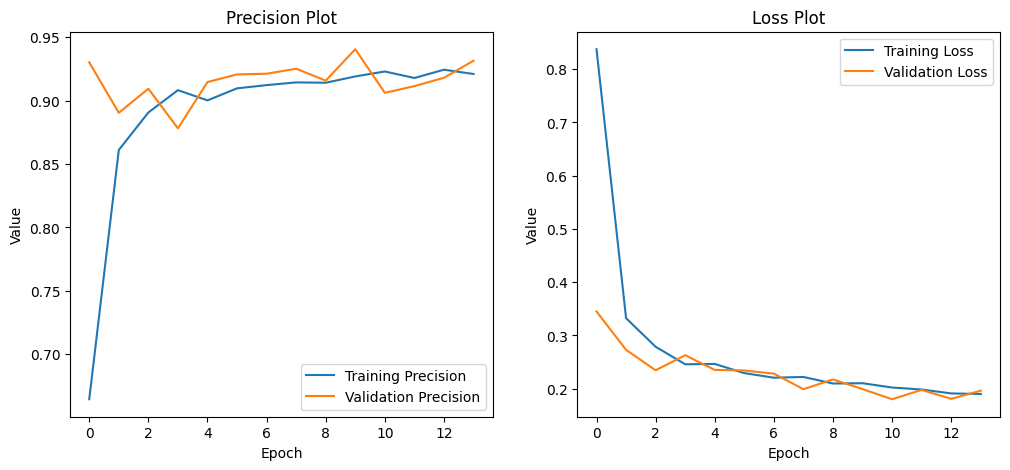

In [38]:
# Membuat figure untuk visualisasi metrik Precision dan Loss selama training
plt.figure(figsize=(12, 5))

# Plot Precision
plt.subplot(1, 2, 1)
plt.plot(seq_training_result.history['precision'], label='Training Precision')
plt.plot(seq_training_result.history['val_precision'], label='Validation Precision')
plt.title('Precision Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(seq_training_result.history['loss'], label='Training Loss')
plt.plot(seq_training_result.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Tampilkan grafik
plt.show()


- Precision Plot menunjukkan:

  - Training Precision meningkat secara konsisten dari awal pelatihan, dimulai dari sekitar 0.68 dan mencapai sekitar 0.91–0.92 pada akhir epoch ke-13. Ini menandakan proses pelatihan berjalan efektif.

  - Validation Precision berada di atas 0.9 sejak awal, namun menunjukkan fluktuasi selama pelatihan, berkisar antara 0.87 hingga 0.94. Meskipun tidak sehalus training precision, nilainya tetap tinggi dan mendekati nilai training.

  - Perbedaan antara training dan validation precision tidak besar, yang menandakan model memiliki kemampuan generalisasi yang cukup baik dan tidak mengalami overfitting berat

- Loss Plot menunjukkan:
  - Training Loss menurun tajam dari sekitar 0.84 pada epoch awal menjadi di bawah 0.2 pada akhir pelatihan. Penurunan ini konsisten dan stabil.

  - Validation Loss juga mengalami penurunan yang cukup seragam, dari sekitar 0.34 menjadi mendekati 0.18. Kurva loss ini mengikuti pola training loss dengan baik.

  - Tidak terdapat gap besar antara training dan validation loss, yang berarti tidak ada indikasi kuat dari overfitting. Model tampaknya belajar secara efektif di kedua dataset.

kesimpulan secara keseluruhan dari kedua plot di atas bahwa model menunjukkan performa yang baik dengan precision tinggi dan loss yang stabil. Meskipun ada sedikit fluktuasi pada validation precision dan loss, model tetap mampu mempertahankan kinerja yang kuat tanpa indikasi overfitting yang tinggi karena nilai yang dihasilkan cukup stabil

### Classification Report

In [39]:
# Melakukan prediksi pada data uji
test_pred = cnn_model.predict(test_flow)

# Mengonversi probabilitas menjadi label biner dengan threshold 0.6
y_pred_test = np.where(test_pred >= 0.6, 1, 0)

# Menampilkan laporan klasifikasi
from sklearn.metrics import classification_report

report = classification_report(
    test_flow.labels,
    y_pred_test,
    target_names=list(test_flow.class_indices.keys())
)

print(report)

4/4 [==============================] - 1s 95ms/step
              precision    recall  f1-score   support

          DR       0.91      0.94      0.93       113
       No_DR       0.94      0.92      0.93       118

    accuracy                           0.93       231
   macro avg       0.93      0.93      0.93       231
weighted avg       0.93      0.93      0.93       231



Berdasarkan hasil evaluasi, diperoleh bahwa akurasi keseluruhan mencapai 93%, yang menunjukkan bahwa sebagian besar prediksi model telah sesuai dengan label sebenarnya dalam dataset pengujian.

Precision dan recall untuk kedua kelas (DR dan No_DR) berada pada rentang 91-94%, mencerminkan bahwa model mampu mendeteksi gambar yang mengindikasikan Diabetic Retinopathy maupun gambar tanpa tanda penyakit dengan tingkat ketepatan yang tinggi.

Nilai F1-score yang seimbang dan tinggi (0.93) untuk kedua kelas menunjukkan bahwa model memiliki keseimbangan yang baik antara kemampuan mendeteksi positif dan negatif, serta tidak menunjukkan bias terhadap salah satu kelas. Hal ini penting dalam konteks diagnosis medis, di mana keseimbangan performa antar kelas sangat krusial untuk menghindari kesalahan deteksi.

### Confussion Matrix

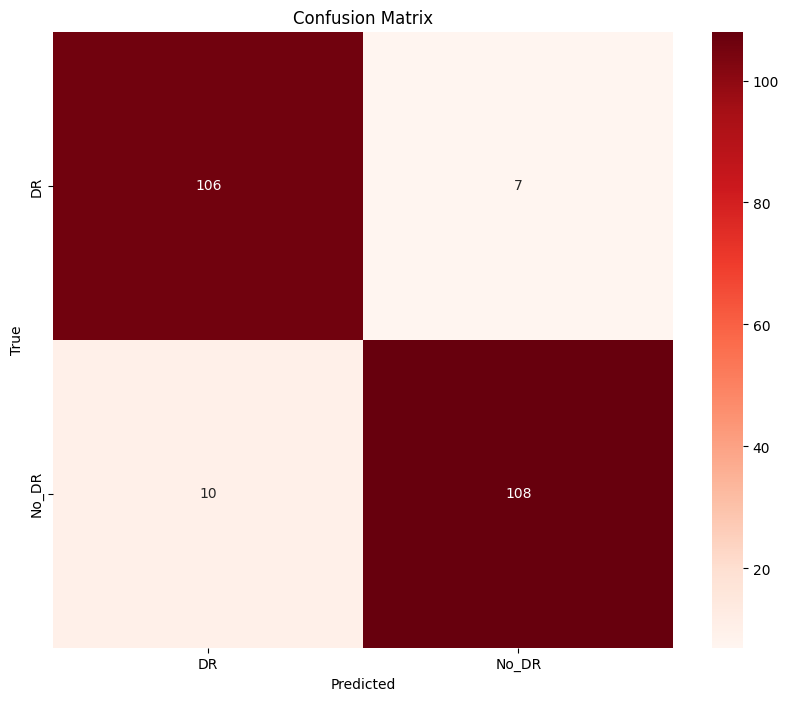

In [40]:
# Ambil label asli dari test set
y_true = test_flow.labels

# Hitung confusion matrix
c_m = confusion_matrix(y_true, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    c_m,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=list(test_flow.class_indices.keys()),
    yticklabels=list(test_flow.class_indices.keys())
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Berdasarkan confusion matrix pada gambar di atas, diperoleh hasil sebagai berikut:

  - True Positive (TP) = 106: Gambar dengan label DR berhasil diklasifikasikan dengan benar sebagai DR.

  - True Negative (TN) = 108: Gambar dengan label No_DR berhasil diklasifikasikan dengan benar sebagai No_DR.

  - False Positive (FP) = 10: Gambar No_DR yang salah diklasifikasikan sebagai DR.

  - False Negative (FN) = 7: Gambar DR yang salah diklasifikasikan sebagai No_DR.

yang artinya:

  - Model mampu mengenali 106 dari 113 gambar DR dengan tepat, hanya membuat kesalahan pada 7 gambar.

  - Sementara itu, dari 118 gambar No_DR, model mengklasifikasikan 108 dengan benar, dan hanya 10 gambar yang keliru diprediksi sebagai DR.

Kesimpulan keseluruhan bahwa model menunjukkan keseimbangan yang sangat baik dalam membedakan antara gambar DR dan No_DR. Tingkat kesalahan klasifikasi yang relatif rendah pada kedua kelas memperkuat bahwa model memiliki akurasi dan ketelitian tinggi untuk tugas deteksi Diabetic Retinopathy berbasis citra retina.

# 7. ANN Improvement (Functional API)

## 7.1 Model Definition

In [41]:
# Membersihkan session sebelumnya dan menetapkan seed agar hasil konsisten
tf.keras.backend.clear_session()
seed = 42
tf.random.set_seed(seed)

# Menentukan bentuk input citra
input_shape = (img_height, img_width, 3)

# Mendefinisikan layer input
image_input = Input(shape=input_shape, name='image_input')

# Dua jalur dense layer yang langsung dihubungkan dari input (meskipun tidak umum untuk citra)
branch1 = Dense(10, activation='relu',
                kernel_initializer=tf.keras.initializers.HeNormal(seed))(image_input)
branch1 = Dense(10, activation='relu',
                kernel_initializer=tf.keras.initializers.HeNormal(seed))(branch1)

branch2 = Dense(10, activation='relu',
                kernel_initializer=tf.keras.initializers.HeNormal(seed))(image_input)
branch2 = Dense(10, activation='relu',
                kernel_initializer=tf.keras.initializers.HeNormal(seed))(branch2)

# Mengubah output kedua jalur menjadi vektor satu dimensi
flatten1 = Flatten()(branch1)
flatten2 = Flatten()(branch2)

# Menggabungkan kedua vektor hasil flatten
merged_output = concatenate([flatten1, flatten2])

# Layer output untuk klasifikasi biner
final_output = Dense(1, activation='sigmoid',
                     kernel_initializer=tf.keras.initializers.GlorotNormal(seed))(merged_output)

# Membuat model Functional
cnn_functional_model = Model(inputs=image_input, outputs=final_output)

# Menyusun model dengan optimizer dan metrik evaluasi
cnn_functional_model.compile(
    optimizer='adamax',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Precision()]
)

# Menampilkan ringkasan arsitektur model
cnn_functional_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 220, 220, 3)]        0         []                            
                                                                                                  
 dense (Dense)               (None, 220, 220, 10)         40        ['image_input[0][0]']         
                                                                                                  
 dense_2 (Dense)             (None, 220, 220, 10)         40        ['image_input[0][0]']         
                                                                                                  
 dense_1 (Dense)             (None, 220, 220, 10)         110       ['dense[0][0]']               
                                                                                              

Model Functional menggunakan dua jalur dense paralel dengan aktivasi ReLU dan inisialisasi HeNormal untuk mengekstraksi representasi fitur dari citra. Meskipun tidak umum, pendekatan ini mengeksplorasi pemrosesan langsung pada input gambar. Output digabung dan diklasifikasikan dengan sigmoid karena target berupa klasifikasi biner. Penggunaan GlorotNormal pada output layer serta binary crossentropy dan metrik precision dipilih untuk mengoptimalkan deteksi Diabetic Retinopathy secara akurat.

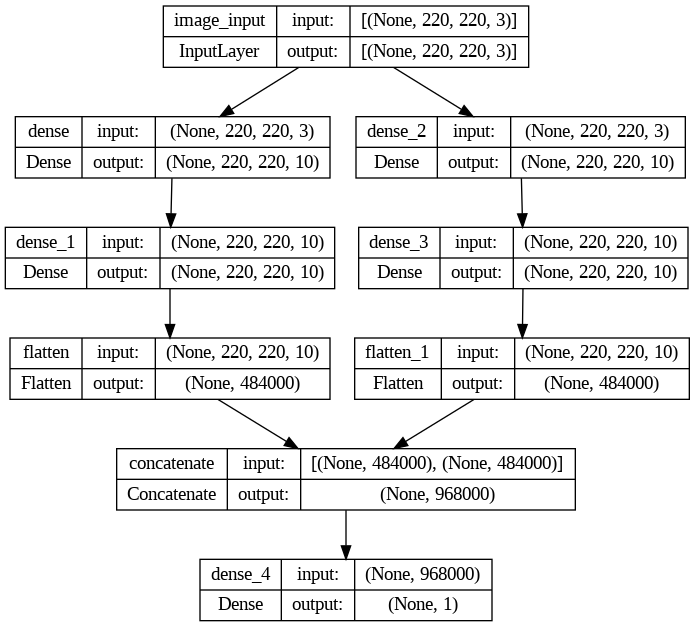

In [42]:
# Membuat arsitektur cnn_functional_model
tf.keras.utils.plot_model(cnn_functional_model, show_shapes=True)

Model yang dibangun menggunakan pendekatan Functional API menampilkan arsitektur bercabang dengan dua jalur paralel yang langsung menerima input gambar berdimensi (220, 220, 3). Masing-masing cabang terdiri dari dua Dense layer berukuran kecil (10 unit), yang kemudian diikuti oleh proses Flatten untuk meratakan output menjadi vektor satu dimensi. Hasil dari kedua cabang ini kemudian digabungkan (concatenate) menjadi satu vektor besar, lalu diteruskan ke Dense layer output dengan aktivasi sigmoid untuk melakukan klasifikasi biner (antara DR dan No_DR)

## 7.2 Model Training

In [43]:
# Menyiapkan callback untuk model functional
func_callback = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('model_functional.keras', save_best_only=True)
]

In [44]:
# Menyusun model functional dengan optimizer dan metrik evaluasi
cnn_functional_model.compile(
    optimizer='adamax',
    loss='binary_crossentropy',
    metrics=tf.keras.metrics.Precision()
)

In [45]:
# Melatih model functional menggunakan data training dan validasi
%%time
functional_training_result = cnn_functional_model.fit(
    train_flow,
    epochs=25,
    validation_data=val_flow,
    callbacks=func_callback
)

Epoch 1/25
33/33 [==============================] - 27s 779ms/step - loss: 8.2341 - precision_1: 0.6275 - val_loss: 1.1699 - val_precision_1: 0.9398
Epoch 2/25
33/33 [==============================] - 26s 771ms/step - loss: 1.4918 - precision_1: 0.7709 - val_loss: 0.9764 - val_precision_1: 0.8149
Epoch 3/25
33/33 [==============================] - 25s 763ms/step - loss: 0.9335 - precision_1: 0.8099 - val_loss: 0.5750 - val_precision_1: 0.9151
Epoch 4/25
33/33 [==============================] - 26s 770ms/step - loss: 0.6932 - precision_1: 0.7849 - val_loss: 0.5918 - val_precision_1: 0.7942
Epoch 5/25
33/33 [==============================] - 25s 768ms/step - loss: 0.5486 - precision_1: 0.8071 - val_loss: 0.3502 - val_precision_1: 0.8778
Epoch 6/25
33/33 [==============================] - 25s 763ms/step - loss: 0.4564 - precision_1: 0.8208 - val_loss: 0.3255 - val_precision_1: 0.8671
Epoch 7/25
33/33 [==============================] - 25s 769ms/step - loss: 0.3612 - precision_1: 0.8419 - 

## 7.3 Model Evaluation

In [46]:
# Mengevaluasi performa model functional pada data pengujian
evaluation_functional = cnn_functional_model.evaluate(test_flow, verbose=0)
print(f'Functional Model - Test Loss     : {evaluation_functional[0]:.4f}')
print(f'Functional Model - Test Precision: {evaluation_functional[1]:.4f}')

Functional Model - Test Loss     : 0.2626
Functional Model - Test Precision: 0.9127


Informasi di atas menunjukkan bahwa model functional menghasilkan test loss sebesar 0.2626 yang mengindikasikan rata-rata error atau kesalahan prediksi relatif rendah dan precision sebesar 0.9127 yang mengindikasikan bahwa model mampu memprediksi setiap label kelas dengan benar sekitar 91%. Hal ini menunjukkan bahwa model mampu mengidentifikasi gambar dengan Diabetic Retinopathy secara cukup akurat, terutama dalam meminimalkan kesalahan pada prediksi positif (yaitu gambar yang benar-benar mengandung DR).

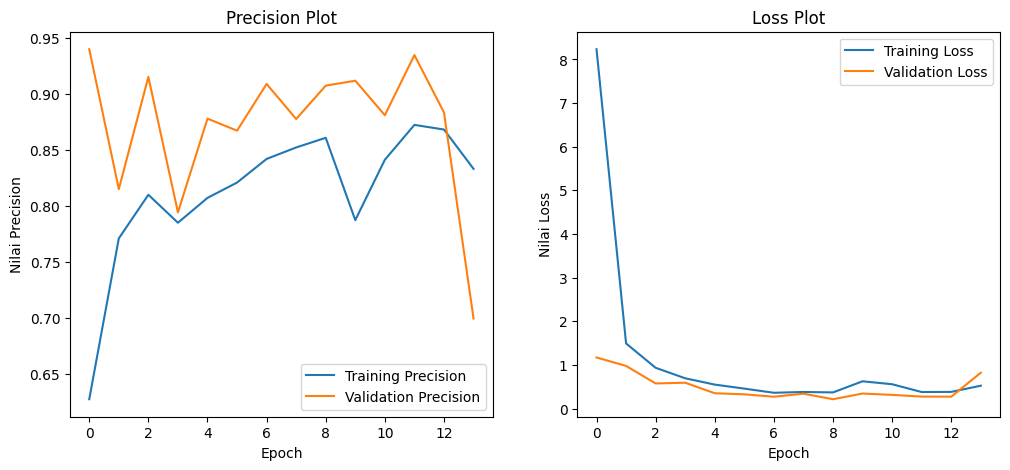

In [47]:
# Membuat visualisasi performa model fungsional
plt.figure(figsize=(12, 5))

# Plot Precision
plt.subplot(1, 2, 1)  # Subplot pertama: Precision
plt.plot(functional_training_result.history['precision_1'], label='Training Precision')
plt.plot(functional_training_result.history['val_precision_1'], label='Validation Precision')
plt.title('Precision Plot')
plt.ylabel('Nilai Precision')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)  # Subplot kedua: Loss
plt.plot(functional_training_result.history['loss'], label='Training Loss')
plt.plot(functional_training_result.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Nilai Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

# Tampilkan hasil visualisasi
plt.show()

- Analisis Precision Plot:

  - Training Precision mengalami peningkatan yang stabil dari awal epoch (sekitar 0.63) hingga mencapai sekitar 0.87 pada epoch ke-11, meskipun terdapat sedikit fluktuasi pada beberapa titik.

  - Validation Precision lebih fluktuatif, namun tetap tinggi, dengan nilai berkisar antara 0.80 hingga 0.94. Nilai ini menunjukkan bahwa model memiliki performa yang baik dalam mendeteksi kelas positif pada data validasi.

  - Di akhir epoch, terjadi penurunan tajam pada validation precision, yang bisa jadi disebabkan oleh overfitting ringan atau noise pada data validasi.



- Analisis Loss Plot:

  - Training Loss menurun drastis dari awal (sekitar 8.2) hingga di bawah 0.5 pada epoch ke-6, menunjukkan proses pembelajaran model berjalan dengan baik.

  - Validation Loss juga menunjukkan penurunan yang konsisten, dari sekitar 1.1 menjadi di bawah 0.4, mengikuti pola serupa dengan training loss.

  - Tidak terlihat perbedaan mencolok atau divergensi besar antara training dan validation loss, kecuali sedikit kenaikan di akhir epoch.

Kesimpulan secara keseluruhan dari kedua plot bahwa model functional menunjukkan kemampuan belajar yang cukup baik pada data training, namun masih kurang stabil pada data validasi. Precision yang tidak konsisten dan validation loss yang berfluktuasi menunjukkan bahwa model belum optimal dalam generalisasi.

### Classification Report

In [48]:
# Melakukan prediksi pada data uji menggunakan model functional
test_pred_func = cnn_functional_model.predict(test_flow)

# Mengubah output probabilitas menjadi label biner (0 atau 1) dengan threshold 0.6
y_pred_test_func = np.where(test_pred_func >= 0.6, 1, 0)

report_functional = classification_report(
    test_flow.labels,
    y_pred_test_func,
    target_names=list(test_flow.class_indices.keys())
)

print(report_functional)

4/4 [==============================] - 1s 99ms/step
              precision    recall  f1-score   support

          DR       0.95      0.91      0.93       113
       No_DR       0.92      0.96      0.94       118

    accuracy                           0.94       231
   macro avg       0.94      0.93      0.93       231
weighted avg       0.94      0.94      0.94       231



Berdasarkan informasi di atas bahwa:
  - Untuk kelas DR, precision sebesar 0.95 dan recall 0.91 menunjukkan bahwa model sangat baik dalam mengidentifikasi gambar retina yang menunjukkan gejala Diabetic Retinopathy, dengan tingkat kesalahan yang rendah dan kemampuan deteksi yang kuat.

  - Untuk kelas No_DR, precision sebesar 0.92 dan recall 0.96 menandakan bahwa model juga sangat efektif dalam mengenali gambar yang tidak mengandung indikasi DR, dengan tingkat sensitivitas yang bahkan lebih tinggi.

  - Nilai f1-score yang tinggi dan merata (0.93-0.94) di kedua kelas menunjukkan bahwa model memiliki keseimbangan yang sangat baik antara presisi dan sensitivitas, serta mampu melakukan klasifikasi dengan konsisten dan akurat terhadap kedua jenis label.

### Confussion Matrix

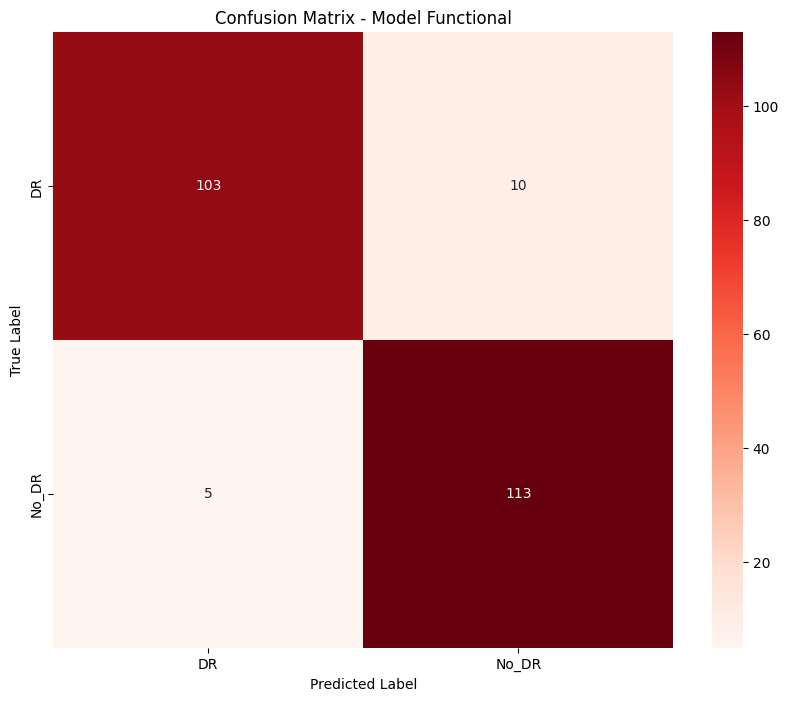

In [49]:
# Mengambil label asli dari test set
y_true_func = test_flow.labels

# Menghitung confusion matrix untuk model functional
cm_func = confusion_matrix(y_true_func, y_pred_test_func)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_func,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=list(test_flow.class_indices.keys()),
    yticklabels=list(test_flow.class_indices.keys())
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model Functional')
plt.show()


Dapat terlihat dari gambar heatmap di atas bahwa:

  - True Positive (TP): 103, True Negative (TN): 113

  - False Positive (FP): 5, False Negative (FN): 10

artinya:

  - Untuk kelas DR, sebanyak 103 gambar berhasil diklasifikasikan dengan benar sebagai DR (True Positive), sementara 10 gambar DR salah diklasifikasikan sebagai No_DR (False Negative).

  - Untuk kelas No_DR, sebanyak 113 gambar dikenali dengan benar (True Negative), dan 5 gambar No_DR salah diklasifikasikan sebagai DR (False Positive)

Kesimpulan keseluruhan:
Model Functional menunjukkan kinerja klasifikasi yang sangat baik, dengan jumlah prediksi benar yang tinggi untuk kedua kelas. Jumlah kesalahan klasifikasi (FN dan FP) tergolong kecil, menandakan bahwa model mampu mendeteksi Diabetic Retinopathy maupun kondisi normal secara seimbang dan akurat.

### Kelebihan dan kekurangan setiap model
1. Model Sequential
  > kelebihan:

  - Performa model sangat stabil, ditunjukkan dengan precision dan loss yang meningkat dan menurun secara konsisten selama pelatihan.

  - Test precision sangat tinggi, menandakan ketepatan klasifikasi yang sangat baik.

  - Tidak menunjukkan tanda-tanda overfitting yang signifikan, karena training dan validation loss bergerak sejajar.

  - Sangat cocok digunakan untuk arsitektur CNN sederhana yang bersifat linier

  > Kekurangan:

  - Kurang fleksibel untuk membangun arsitektur kompleks (misalnya: skip connection, multiple input/output).

  - Tidak cocok jika model membutuhkan struktur bercabang atau paralel seperti pada model Functional.

2. Model Functional:

  >Kelebihan:

  - Fleksibel untuk membuat arsitektur kompleks, cocok untuk eksperimen lebih lanjut dan deep learning tingkat lanjut.

  - Mendukung berbagai bentuk kombinasi layer dan multi-input/output.

  > Kekurangan:

  - Dalam proyek ini, performa kurang stabil, precision dan loss menunjukkan fluktuasi besar.

  - Hasil evaluasi pada data uji menunjukkan precision lebih rendah dibanding Sequential.

  - Cenderung lebih rawan overfitting dalam arsitektur yang belum optimal

Jika dilihat dari hasil analisis plot precision dan plot loss setiap model yang telah dilakukan:
- kesimpulan plot precision: Model Sequential lebih stabil dan konsisten, terutama pada validation precision yang tidak mengalami penurunan tajam. Lebih dapat diandalkan dalam generalisasi.
- kesimpulan plot loss: Kedua model menunjukkan penurunan loss yang baik, namun model Sequential lebih stabil tanpa kenaikan akhir, menjadikannya lebih robust.

## Keputusan menentukan model terbaik
Berdasarkan hasil evaluasi yang telah dilakukan, model Sequential menunjukkan performa yang lebih unggul dibandingkan model Functional dalam mendeteksi Diabetic Retinopathy dari citra retina.

Selain itu, grafik evaluasi menunjukkan bahwa model sequential memiliki kurva loss dan precision yang lebih stabil dibandingkan model functional, yang mengalami fluktuasi pada precision dan validation loss. Maka dapat disimpulkan bahwa Model Sequential lebih konsisten, stabil, dan akurat dalam mengenali citra DR dan No_DR, sehingga dipilih sebagai model akhir untuk disimpan dan digunakan pada proses inference selanjutnya.

# 8. Model Saving

In [51]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [52]:
# Freeze model

cnn_model.trainable = False
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [53]:
# Menyimpan model Sequential
cnn_model.save('model_sequential.hdf5')

# 9. Model Inference
dikerjakan pada file notebook ```model_inference.ipynb```

# 10. Conclusion

1. Dataset:
  - Sumber dataset berasal dari kaggle berjudul "Diagnosis of Diabetic Retinopathy"
  - Dataset yang digunakan dalam proyek ini terbagi ke dalam tiga subset, yaitu train set, validation set, dan test set, dengan distribusi kelas yang cukup seimbang
  - Pada train set, terdapat 1.050 gambar dengan label DR dan 1.026 gambar dengan label No_DR. Sementara itu, validation set terdiri dari 245 gambar DR dan 286 gambar No_DR. Adapun test set mencakup 113 gambar DR dan 118 gambar No_DR.
  - label kelas DR dan No_DR kemudian dikonversikan ke dalam numerik binary menjadi 0 untuk kelas DR dan 1 untuk kelas No_DR
2. Data Preprocessing:

  Setelah dilakukan proses augmentasi data, jumlah citra pada masing-masing subset mengalami peningkatan yang signifikan. Pada train set, total terdapat 2.076 gambar yang terbagi ke dalam dua kelas, yaitu DR dan No_DR. Sementara itu, pada validation set terdapat 532 gambar yang juga terdiri dari kedua kelas tersebut. Adapun pada test set, terdapat 231 gambar yang mencakup gambar dari kelas DR maupun No_DR. Hal ini menunjukkan bahwa augmentasi berhasil memperkaya jumlah data terutama pada train set, sehingga dapat membantu model belajar lebih baik dan menghindari overfitting.
3. Modeling:

  Terdapat 2 model yang diuji dalam training dan evaluasi yaitu model sequential dan model functional untuk menentukan model yang terbaik agar dilakukan ke tahap model inference

4. Analisis evaluasi setiap model:
  - berdasarkan precision plot:
    - Model Sequential menunjukkan peningkatan precision yang stabil dan konsisten, baik pada training maupun validation. Nilai validation precision tetap tinggi (sekitar 0.87-0.94) dan tidak mengalami penurunan signifikan.
    - Model Functional mengalami fluktuasi yang lebih besar, terutama pada validation precision yang sempat turun tajam di akhir epoch, meskipun sempat mencapai nilai tinggi di tengah pelatihan.
  - berdasarkan loss plot:
    - Model Sequential menunjukkan penurunan training dan validation loss yang konsisten, tanpa adanya divergensi di akhir epoch.
    - Model Functional juga mengalami penurunan loss, namun terdapat sedikit peningkatan pada validation loss di akhir epoch, yang mengindikasikan potensi overfitting ringan.
  - berdasarkan confussion matrix (heatmap):
    - Model Sequential lebih baik dalam mendeteksi gambar DR (True Positive lebih tinggi), tetapi sedikit lebih banyak salah deteksi terhadap gambar No_DR (False Positive).
    - Model Functional lebih baik dalam menghindari salah deteksi pada gambar No_DR (False Positive lebih rendah), tetapi lebih banyak meloloskan gambar DR (False Negative lebih tinggi).
    > yang artinya Jika deteksi DR lebih penting (misalnya untuk diagnosis dini), Sequential lebih unggul. Jika ingin minim false alarm terhadap pasien sehat, Functional sedikit lebih konservatif.
5. Keputusan pemilihan model terbaik:

  Secara keseluruhan, Model Sequential menunjukkan performa yang lebih stabil, minim overfitting, dan lebih unggul dalam mendeteksi kasus positif DR, yang merupakan aspek krusial dalam konteks deteksi penyakit.
6. Insight terkait business:
  - Pemilihan Model Sequential sebagai model terbaik berdasarkan evaluasi teknis menunjukkan bahwa sistem ini memiliki potensi tinggi untuk diimplementasikan dalam dunia klinis, terutama dalam mendukung proses skrining otomatis Diabetic Retinopathy (DR). Dengan tingkat akurasi dan precision yang tinggi serta stabilitas performa selama pelatihan, model ini dapat membantu meningkatkan efisiensi dan ketepatan dalam mendeteksi DR sejak dini.
  - Insight bisnis utama yang dapat ditarik adalah bahwa penggunaan model berbasis deep learning seperti ini dapat menghemat waktu diagnosis, mengurangi beban kerja dokter spesialis mata, serta memungkinkan skrining massal pada populasi dengan risiko tinggi, terutama di daerah yang kekurangan tenaga medis.
7. Saran untuk implementasi lanjutan:

  - Validasi di Dunia Nyata:
  model perlu diuji pada data retina dari berbagai perangkat dan kondisi untuk memastikan akurasi tetap tinggi di lingkungan klinis nyata.

  - Integrasi ke Sistem Klinik:
  model dapat dihubungkan dengan sistem EMR atau platform radiologi agar dokter bisa langsung melihat hasil prediksi sebagai alat bantu diagnosis.

  - Monitoring & Pembaruan Model:
  performa model harus dipantau secara rutin dan diperbarui dengan data terbaru agar tetap akurat dan relevan seiring waktu.






